
Logistic Regression
Accuracy: 0.81, Recall: 0.74, F1: 0.76
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Confusion Matrix:
[[90 15]
 [19 55]]

Decision Tree
Accuracy: 0.80, Recall: 0.69, F1: 0.74
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Confusion Matrix:
[[92 13]
 [23 51]]

Random Forest
Accuracy: 0.82, Recall: 0.76, F1: 0.78
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      

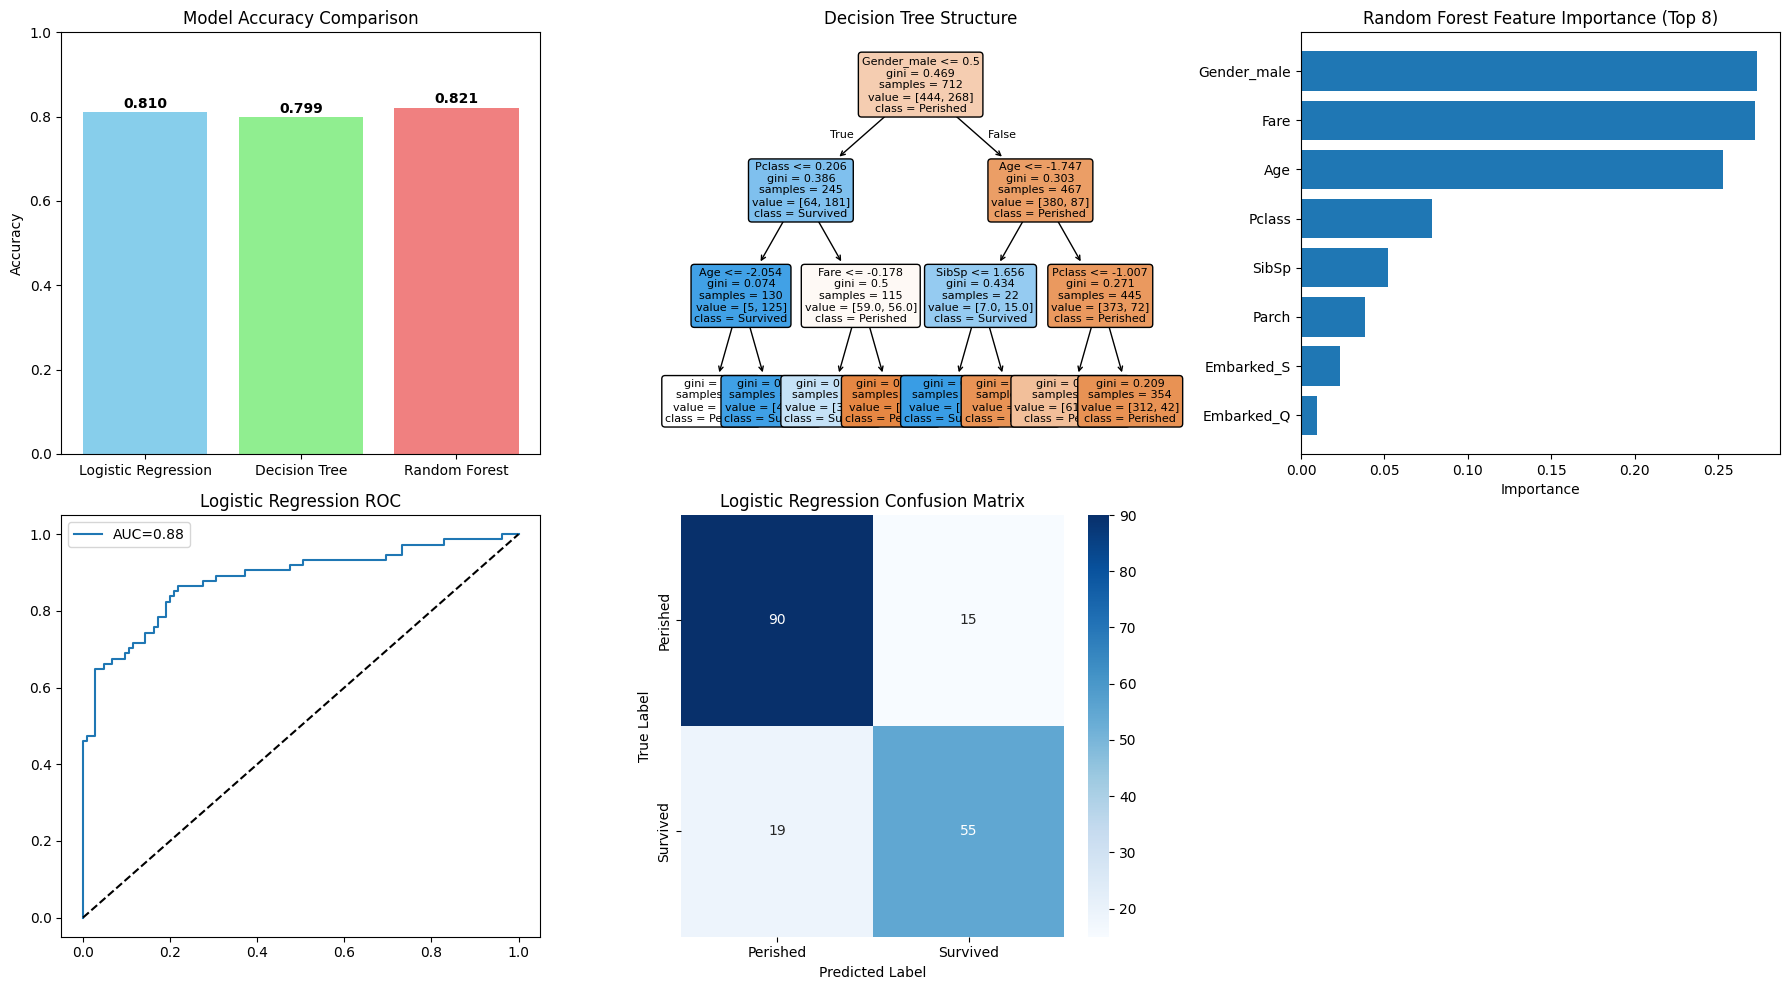

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix


# 1. load and pr
df = pd.read_csv("Titanic.csv")
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# 2. Identify feature types
target = 'Survived'
X = df.drop(target, axis=1)
y = df[target]

nf = X.select_dtypes(include=np.number).columns.tolist()
cf = X.select_dtypes(include=['object']).columns.tolist()

# 3. Create ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), nf),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), cf)
])

# 4. Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Define models
lr = Pipeline([('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000, random_state=42))])
dt = Pipeline([('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))])
rf = Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

models = {'Logistic Regression': lr, 'Decision Tree': dt, 'Random Forest': rf}

# 6. Train and predict
y_preds = {}
accuracies = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Fit model
    y_pred = model.predict(X_test)
    y_preds[name] = y_pred
    accuracies[name] = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name}")
    print(f"Accuracy: {accuracies[name]:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# 7. Extract feature names for Logistic Regression and tree-based models
cat_encoder = lr.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
all_features = nf + list(cat_encoder.get_feature_names_out(cf))

# Logistic Regression Coefficients
coef_df = pd.DataFrame({'Feature': all_features,
                        'Coefficient': lr.named_steps['classifier'].coef_[0]})
print("\nLogistic Regression Coefficients:")
print(coef_df.sort_values('Coefficient', ascending=False))

# Random Forest Feature Importances
rf_importances = rf.named_steps['classifier'].feature_importances_
rf_feat_df = pd.DataFrame({'Feature': all_features, 'Importance': rf_importances})
print("\nRandom Forest Feature Importances:")
print(rf_feat_df.sort_values('Importance', ascending=False))

# Decision Tree Feature Importances
dt_importances = dt.named_steps['classifier'].feature_importances_
dt_feat_df = pd.DataFrame({'Feature': all_features, 'Importance': dt_importances})
print("\nDecision Tree Feature Importances:")
print(dt_feat_df.sort_values('Importance', ascending=False))

# 8. Visualization
plt.figure(figsize=(18, 10))

# Accuracy comparison
plt.subplot(2,3,1)
plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue','lightgreen','lightcoral'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0,1)
for i,v in enumerate(accuracies.values()):
    plt.text(i, v+0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Decision Tree
plt.subplot(2,3,2)
plot_tree(dt.named_steps['classifier'], feature_names=all_features,
          class_names=['Perished','Survived'], filled=True, rounded=True, fontsize=8)
plt.title('Decision Tree Structure')

# Random Forest top 8 features
plt.subplot(2,3,3)
top_indices = np.argsort(rf_importances)[-8:]
plt.barh(range(len(top_indices)), rf_importances[top_indices])
plt.yticks(range(len(top_indices)), [all_features[i] for i in top_indices])
plt.title('Random Forest Feature Importance (Top 8)')
plt.xlabel('Importance')

# Logistic Regression ROC
plt.subplot(2,3,4)
y_prob = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.title("Logistic Regression ROC")
plt.legend()

# Logistic Regression Confusion Matrix
plt.subplot(2,3,5)
sns.heatmap(confusion_matrix(y_test, y_preds['Logistic Regression']),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Perished','Survived'],
            yticklabels=['Perished','Survived'])
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()
